In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

Need to interpolate eocene data onto NEMO grid 720x360 or interpolate both on a regular grid 

In [26]:
path_modern = "/lus/h2resw01/hpcperm/ccpd/ECE4-DATA/nemo"
path_eocene = "/perm/itas/data/deepMIP/Herold_etal_2014"

In [27]:
topo_eocene = xr.open_dataset(f"{path_eocene}/herold_etal_eocene_topo_1x1.nc")
domain_modern = xr.open_dataset(f"{path_modern}/domain/ORCA1/domain_cfg.nc")

In [38]:
iwm_modern = xr.open_dataset(f"{path_modern}/initial/zdfiwm_forcing_r720x360.nc")
iwm_eocene = xr.open_dataset(f"{path_eocene}/Green_Huber_eocene_tidal_dissipation_1x1.nc")

In [28]:
topo_eocene['bathymetry'] = -topo_eocene['topo'].where(topo_eocene['topo'] < 0)

In [41]:
iwm_modern

<xarray.Dataset> Size: 15MB
Dimensions:     (latitude: 360, longitude: 720)
Coordinates:
  * latitude    (latitude) float64 3kB -90.0 -89.5 -89.0 ... 88.5 89.0 89.5
  * longitude   (longitude) float64 6kB 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
Data variables:
    power_bot   (latitude, longitude) float64 2MB ...
    power_cri   (latitude, longitude) float64 2MB ...
    power_nsq   (latitude, longitude) float64 2MB ...
    power_sho   (latitude, longitude) float64 2MB ...
    scale_cri   (latitude, longitude) float64 2MB ...
    scale_bot   (latitude, longitude) float64 2MB ...
    bathymetry  (latitude, longitude) float64 2MB ...
Attributes:
    CDI:                       Climate Data Interface version 1.9.8 (https://...
    Conventions:               CF-1.6
    history:                   Sun Aug 04 00:59:55 2024: cdo -L -P 16 -remapn...
    CDO:                       Climate Data Operators version 1.9.8 (https://...
    cdo_openmp_thread_number:  16

Text(0.5, 0, 'bathymetry [m]')

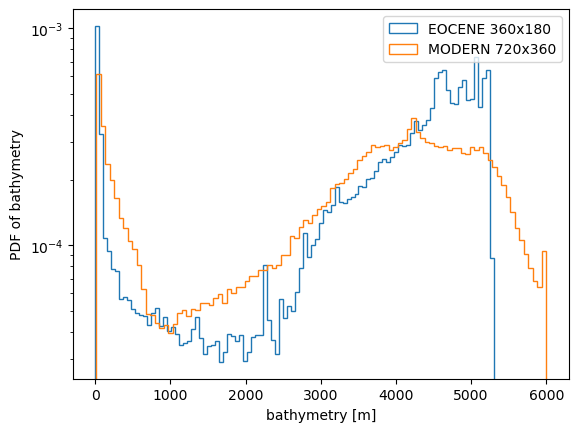

In [42]:
plt.hist(topo_eocene['bathymetry'].values.flatten(), density=True, bins=100, histtype="step", label='EOCENE 360x180')
plt.hist(iwm_modern['bathymetry'].values.flatten(), density=True, bins=100, histtype="step", label='MODERN 720x360')
plt.yscale('log')
plt.legend(loc="upper right")
plt.ylabel('PDF of bathymetry')
plt.xlabel('bathymetry [m]')

In [70]:
#iwm_modern['mask'] = (~iwm_modern['bathymetry'].isnull()).astype(int)
iwm_modern['mask'] = iwm_modern['bathymetry'].where(iwm_modern['bathymetry'].isnull(), 1)

In [71]:
iwm_modern['tidal_dissipation'] = iwm_modern['mask'] * (iwm_modern['power_bot']+iwm_modern['power_cri']+iwm_modern['power_nsq']+iwm_modern['power_sho'])

Text(0.5, 0, 'ratio')

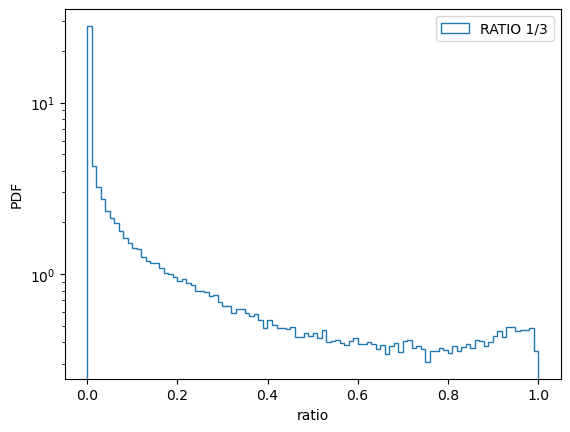

In [73]:
ratio = iwm_modern['power_cri']/iwm_modern['tidal_dissipation']
plt.hist(ratio.values.flatten(), density=True, bins=100, histtype="step", label='RATIO 1/3')
plt.yscale('log')
plt.legend(loc="upper right")
plt.ylabel('PDF')
plt.xlabel('ratio')

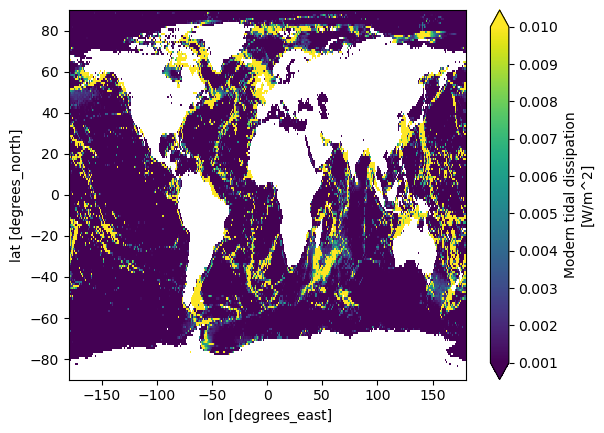

In [68]:
iwm_eocene['mod_tidal_dissipation'].plot(vmin=0.001, vmax=0.01)

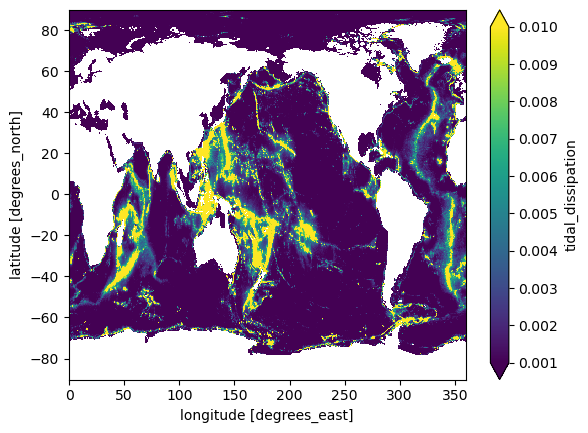

In [72]:
iwm_modern['tidal_dissipation'].plot(vmin=0.001, vmax=0.01)

Text(0.5, 0, 'bathymetry [m]')

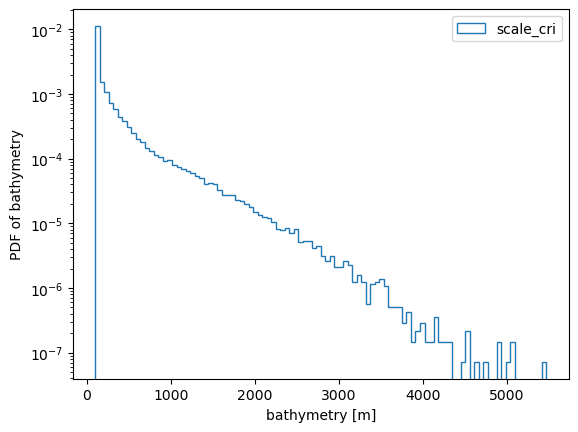

In [ ]:
plt.hist(iwm_modern['scale_cri'].values.flatten(), density=True, bins=100, histtype="step", label='scale_cri')
#plt.hist(iwm_modern['scale_bot'].values.flatten(), density=True, bins=100, histtype="step", label='scale_bot')
plt.yscale('log')
plt.legend(loc="upper right")
plt.ylabel('PDF')
plt.xlabel('scale critical [m]')

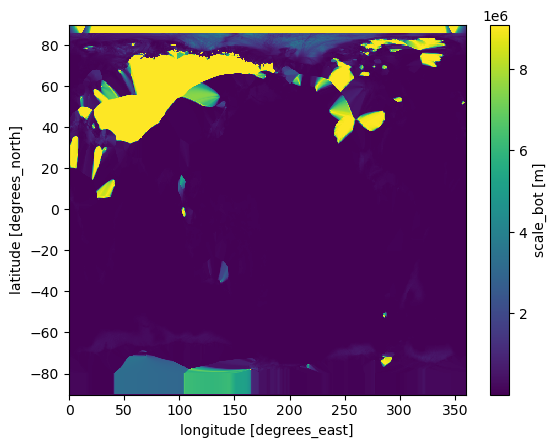

In [46]:
iwm_modern['scale_bot'].plot()

In [47]:
iwm_eocene

<xarray.Dataset> Size: 1MB
Dimensions:                (lat: 180, lon: 360)
Coordinates:
  * lat                    (lat) float32 720B -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon                    (lon) float32 1kB -179.5 -178.5 ... 178.5 179.5
Data variables:
    eo_tidal_dissipation   (lat, lon) float64 518kB ...
    mod_tidal_dissipation  (lat, lon) float64 518kB ...
Attributes:
    title:    Green and Huber (2013) modern and Eocene tidal dissipation.

Text(0.5, 0, 'tidal dissipation [W/m^2]')

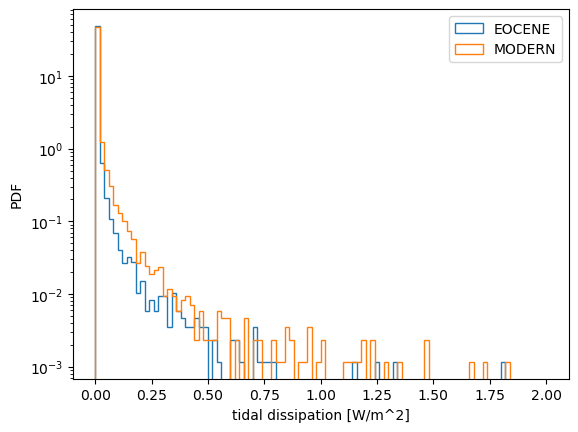

In [51]:
plt.hist(iwm_eocene['eo_tidal_dissipation'].values.flatten(), density=True, bins=100, range=[0.0, 2.0], histtype="step", label='EOCENE')
plt.hist(iwm_eocene['mod_tidal_dissipation'].values.flatten(), density=True, bins=100, range=[0.0, 2.0], histtype="step", label='MODERN')
plt.yscale('log')
plt.legend(loc="upper right")
plt.ylabel('PDF')
plt.xlabel('tidal dissipation [W/m^2]')